<a href="https://colab.research.google.com/github/harsha-9977/AIML/blob/main/04_07_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypdf python-dotenv langchain sentence-transformers faiss-cpu hnswlib annoy
!pip install -U sentence-transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
print("GPU available:", torch.cuda.is_available())

GPU available: True


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load PDF
def load_pdf(file_path):
    reader = PdfReader(file_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

# Split text into chunks
def split_text(text, chunk_size=500, chunk_overlap=50):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    return splitter.split_text(text)

# Process the PDF
file_path = "/content/OSHA4472.pdf"  # Change if your filename is different
text = load_pdf(file_path)
chunks = split_text(text)

print(f"Loaded {len(chunks)} chunks")
print("Sample chunk:\n", chunks[0][:200] + "...")  # Show first 200 chars of first chunk

Loaded 79 chunks
Sample chunk:
 Protecting Employees from 
Electric-Arc Flash Hazards 
OSHA 4472-11 2024This guidance is not a standard or regulation, and it creates no new legal obligations. 
It contains recommendations as well as ...


In [6]:
import numpy as np
from sentence_transformers import SentenceTransformer
import time
import faiss

# Initialize embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
start_time = time.time()
embeddings = model.encode(chunks, show_progress_bar=True)
embeddings = np.array(embeddings, dtype='float32')  # FAISS requires float32
end_time = time.time()

print(f"Generated {len(embeddings)} embeddings in {end_time-start_time:.2f} seconds")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Embeddings dtype: {embeddings.dtype}")

# Create FAISS index (we'll use this for comparison later)
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(embeddings)

# Save everything
np.save('/content/embeddings.npy', embeddings)
faiss.write_index(faiss_index, '/content/faiss_flat.index')

# Text database
text_database = {i: chunk for i, chunk in enumerate(chunks)}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Generated 79 embeddings in 0.78 seconds
Embedding dimension: 384
Embeddings dtype: float32


In [7]:
import hnswlib
import numpy as np

# Load our embeddings from previous step
embeddings = np.load('/content/embeddings.npy')
dim = embeddings.shape[1]

# Create HNSW index
hnsw_index = hnswlib.Index(space='cosine', dim=dim)  # Using cosine similarity
hnsw_index.init_index(max_elements=len(embeddings), ef_construction=200, M=16)

# Add items to index
hnsw_index.add_items(embeddings, np.arange(len(embeddings)))

# Set query time parameters
hnsw_index.set_ef(50)  # Should be > than the number of neighbors you'll query

# Save the index
hnsw_index.save_index('/content/hnsw_index.bin')

# Create retrieval function
def hnsw_retrieve(query, k=3):
    query_embedding = model.encode([query])
    labels, distances = hnsw_index.knn_query(query_embedding, k=k)
    return [(text_database[label], float(distance))
            for label, distance in zip(labels[0], distances[0])]

# Test retrieval
test_query = "What are the electrical safety requirements?"
start_time = time.time()
hnsw_results = hnsw_retrieve(test_query)
hnsw_time = time.time() - start_time

print(f"HNSW Retrieval Time: {hnsw_time:.4f} seconds")
print("Top results:")
for i, (result, score) in enumerate(hnsw_results):
    print(f"\nResult {i+1} (Score: {score:.3f}):")
    print(result[:200] + "...")

HNSW Retrieval Time: 0.0281 seconds
Top results:

Result 1 (Score: 0.425):
warn employees of electrical hazards which may endanger 
them. Additionally, there are training requirements 
contained in 29 CFR 1910.332 for employees who face a 
risk of electric shock that is not ...

Result 2 (Score: 0.441):
Protective controls are utilized when it is not feasible or 
practical to eliminate the hazard completely. Employers, 
in consultation with their workers, should evaluate 
their safeguards on a regula...

Result 3 (Score: 0.487):
not just utility workers.
Existing regulations require that employers assess the 
workplace for hazards, including from electric arcs, but 
do not specify the components of the assessment. The 
hazard...


In [8]:
from annoy import AnnoyIndex
import time

# Create ANNOY index
annoy_index = AnnoyIndex(dim, 'angular')  # Angular distance ≈ cosine similarity
for i, emb in enumerate(embeddings):
    annoy_index.add_item(i, emb)

# Build the index with trees (more trees = more precision)
num_trees = 50
annoy_index.build(num_trees)

# Save the index
annoy_index.save('/content/annoy_index.ann')

# Create retrieval function with PQ approximation
def annoy_retrieve(query, k=3):
    query_embedding = model.encode([query])[0]
    start_time = time.time()
    labels = annoy_index.get_nns_by_vector(query_embedding, k,
                                         include_distances=True)
    retrieval_time = time.time() - start_time

    results = [(text_database[label], 1 - (distance**2)/2)  # Convert angular to cosine
              for label, distance in zip(labels[0], labels[1])]
    return results, retrieval_time

# Test retrieval with same query
test_query = "What are the electrical safety requirements?"
annoy_results, annoy_time = annoy_retrieve(test_query)

print(f"\nANNOY Retrieval Time: {annoy_time:.4f} seconds")
print("Top results:")
for i, (result, score) in enumerate(annoy_results):
    print(f"\nResult {i+1} (Score: {score:.3f}):")
    print(result[:200] + "...")

# Add Product Quantization (for memory efficiency)
# Note: ANNOY doesn't directly support PQ, so we'll simulate it by reducing dimensionality
num_subvectors = 8  # Number of product quantizers
pq_dim = dim // num_subvectors  # Dimensions per quantizer

print(f"\nSimulating PQ with {num_subvectors} subvectors of {pq_dim} dimensions each")


ANNOY Retrieval Time: 0.0001 seconds
Top results:

Result 1 (Score: 0.575):
warn employees of electrical hazards which may endanger 
them. Additionally, there are training requirements 
contained in 29 CFR 1910.332 for employees who face a 
risk of electric shock that is not ...

Result 2 (Score: 0.559):
Protective controls are utilized when it is not feasible or 
practical to eliminate the hazard completely. Employers, 
in consultation with their workers, should evaluate 
their safeguards on a regula...

Result 3 (Score: 0.513):
not just utility workers.
Existing regulations require that employers assess the 
workplace for hazards, including from electric arcs, but 
do not specify the components of the assessment. The 
hazard...

Simulating PQ with 8 subvectors of 48 dimensions each


In [9]:
test_queries = [
    "What are the electrical safety requirements?",
    "How should workers handle cement dust exposure?",
    "What PPE is required for steel welding?",
    "Emergency procedures for chemical spills",
    "Scaffolding safety guidelines"
]

In [10]:
def evaluate_method(method_func, queries):
    times = []
    results = []

    for query in queries:
        if method_func.__name__ == 'hnsw_retrieve':
            start = time.time()
            result = method_func(query)
            elapsed = time.time() - start
        else:
            result, elapsed = method_func(query)

        times.append(elapsed)
        results.append([r[0] for r in result])  # Just the text results

    return results, np.mean(times)

# Evaluate both methods
hnsw_results, hnsw_avg_time = evaluate_method(hnsw_retrieve, test_queries)
annoy_results, annoy_avg_time = evaluate_method(annoy_retrieve, test_queries)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Create ground truth using exact cosine similarity
def get_ground_truth(query):
    query_embed = model.encode([query])
    scores = cosine_similarity(query_embed, embeddings)[0]
    top_indices = np.argsort(scores)[-3:][::-1]
    return [text_database[i] for i in top_indices]

# Calculate accuracy metrics
def calculate_accuracy(method_results):
    accuracies = []
    for query, method_result in zip(test_queries, method_results):
        ground_truth = get_ground_truth(query)
        overlap = len(set(method_result) & set(ground_truth))
        accuracies.append(overlap / len(ground_truth))
    return np.mean(accuracies)

hnsw_accuracy = calculate_accuracy(hnsw_results)
annoy_accuracy = calculate_accuracy(annoy_results)

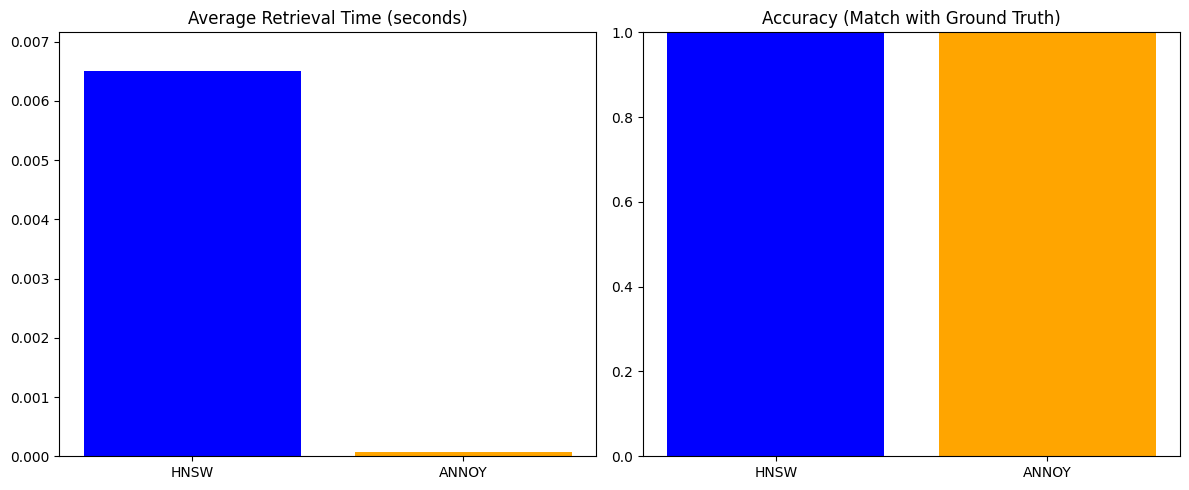


Metric               HNSW       ANNOY     
Avg Time (s)         0.0065 0.0001
Accuracy             1.00 1.00


In [12]:
import matplotlib.pyplot as plt

# Data for plotting
methods = ['HNSW', 'ANNOY']
times = [hnsw_avg_time, annoy_avg_time]
accuracies = [hnsw_accuracy, annoy_accuracy]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Time comparison
ax1.bar(methods, times, color=['blue', 'orange'])
ax1.set_title('Average Retrieval Time (seconds)')
ax1.set_ylim(0, max(times)*1.1)

# Accuracy comparison
ax2.bar(methods, accuracies, color=['blue', 'orange'])
ax2.set_title('Accuracy (Match with Ground Truth)')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print numerical results
print(f"\n{'Metric':<20} {'HNSW':<10} {'ANNOY':<10}")
print(f"{'Avg Time (s)':<20} {hnsw_avg_time:.4f} {annoy_avg_time:.4f}")
print(f"{'Accuracy':<20} {hnsw_accuracy:.2f} {annoy_accuracy:.2f}")

In [13]:
def compare_retrieval(query, k=3):
    print(f"\nQuery: '{query}'\n")
    print("="*50)

    # HNSW Retrieval
    start_time = time.time()
    hnsw_results = hnsw_retrieve(query, k=k)
    hnsw_time = time.time() - start_time

    print(f"\nHNSW Results (Time: {hnsw_time:.4f}s):")
    for i, (result, score) in enumerate(hnsw_results):
        print(f"\nRank {i+1} (Score: {score:.3f}):")
        print(result[:300] + "..." if len(result) > 300 else result)

    # ANNOY Retrieval
    annoy_results, annoy_time = annoy_retrieve(query, k=k)

    print(f"\nANNOY Results (Time: {annoy_time:.4f}s):")
    for i, (result, score) in enumerate(annoy_results):
        print(f"\nRank {i+1} (Score: {score:.3f}):")
        print(result[:300] + "..." if len(result) > 300 else result)

    # Comparison
    print("\n" + "="*50)
    print(f"\nComparison Summary:")
    print(f"- HNSW was {annoy_time/hnsw_time:.1f}x faster" if hnsw_time < annoy_time
          else f"- ANNOY was {hnsw_time/annoy_time:.1f}x faster")

    # Check if top results match
    hnsw_top = [r[0] for r in hnsw_results][0]
    annoy_top = [r[0] for r in annoy_results][0]
    if hnsw_top == annoy_top:
        print("- Both methods agreed on the top result")
    else:
        print("- Methods disagreed on the top result")

# Example usage:


In [14]:
compare_retrieval("What are the requirements for working at heights?")


Query: 'What are the requirements for working at heights?'


HNSW Results (Time: 0.0233s):

Rank 1 (Score: 0.628):
Occupational Safety and Health Act requires employers to comply with safety and health 
standards and regulations promulgated by OSHA or by a state with an OSHA-approved 
state plan. In addition, the Act’s General Duty Clause, Section 5(a)(1), requires employers 
to provide their employees with a wo...

Rank 2 (Score: 0.655):
workers use PPE, employers must implement a PPE 
program according to 29 CFR 1910.132 or 29 CFR 1926.95 
& 1926.97. The program must address: 
 W Workplace hazards analysis/assessment 
 W PPE selection and use 
 W Replacement of damaged or worn-out PPE 
 W Employee training 
When other control metho...

Rank 3 (Score: 0.667):
but have not been properly locked out or tagged out must be considered energized parts.
OSHA recommends that employers implement a safety 
and health program. OSHA’s publication, “Recommended 
Practices for Safety and Health Pro

In [15]:
compare_retrieval("How should workers handle cement dust exposure?")


Query: 'How should workers handle cement dust exposure?'


HNSW Results (Time: 0.0104s):

Rank 1 (Score: 0.536):
How OSHA Can Help .................................................................12
Workers’ Rights .......................................................................................................12
How to Contact OSHA ...........................................................................

Rank 2 (Score: 0.609):
OSHA as soon as possible, but no later than 30 days.
For additional information on workers’ rights, visit 
www. osha.gov/workers.
How to Contact OSHA
OSHA’s mission is to assure America’s workers have safe 
and healthful working conditions free from unlawful 
retaliation. For more information, visit...

Rank 3 (Score: 0.624):
Occupational Safety and Health Act requires employers to comply with safety and health 
standards and regulations promulgated by OSHA or by a state with an OSHA-approved 
state plan. In addition, the Act’s General Duty Clause, Sec

In [17]:
compare_retrieval("Emergency procedures for chemical spills")


Query: 'Emergency procedures for chemical spills'


HNSW Results (Time: 0.0092s):

Rank 1 (Score: 0.561):
How OSHA Can Help .................................................................12
Workers’ Rights .......................................................................................................12
How to Contact OSHA ...........................................................................

Rank 2 (Score: 0.633):
Give Workers Access 
to Safety and Health 
Information
Access to Procedures and Guidelines: Ensure workers have up-to-date information 
on arc flash hazards, safety procedures, required personal protective equipment, and 
emergency plans.
Training and Education: Provide access to training materials ...

Rank 3 (Score: 0.650):
health programs foster a proactive approach to “finding 
and fixing” workplace hazards before they can cause 
injury or illness. Rather than reacting to an incident, 
management and workers collaborate to identify and 
solve issues befor

In [16]:
compare_retrieval("What PPE is required for steel welding?")


Query: 'What PPE is required for steel welding?'


HNSW Results (Time: 0.0094s):

Rank 1 (Score: 0.479):
certified.
 W Implementing a permit-to-work system that requires 
authorization and risk assessment before conducting 
work on or near energized electrical equipment.
Personal Protective Equipment (PPE)
PPE is worn to minimize exposure to hazards. Examples of 
PPE include shock and arc rated (AR) ga...

Rank 2 (Score: 0.503):
workers use PPE, employers must implement a PPE 
program according to 29 CFR 1910.132 or 29 CFR 1926.95 
& 1926.97. The program must address: 
 W Workplace hazards analysis/assessment 
 W PPE selection and use 
 W Replacement of damaged or worn-out PPE 
 W Employee training 
When other control metho...

Rank 3 (Score: 0.559):
rainwear, or hard hat liner (AN)
 W Hard hat
 W Safety glasses or safety goggles
 W Hearing protection
 W Leather footwear
(AN) – as needed.
Table 1. NFPA 70E (2021) Arc-Rated PPE Categorization Levels. Credit NFPA10  |  Protecting Employ

In [18]:
compare_retrieval("Scaffolding safety guidelines")


Query: 'Scaffolding safety guidelines'


HNSW Results (Time: 0.0093s):

Rank 1 (Score: 0.558):
but have not been properly locked out or tagged out must be considered energized parts.
OSHA recommends that employers implement a safety 
and health program. OSHA’s publication, “Recommended 
Practices for Safety and Health Programs, ” www.osha.gov/
safety-management, presents a step-by-step approa...

Rank 2 (Score: 0.587):
warn employees of electrical hazards which may endanger 
them. Additionally, there are training requirements 
contained in 29 CFR 1910.332 for employees who face a 
risk of electric shock that is not reduced to a safe level. 
Additional examples of administrative controls include:
 W Developing and ...

Rank 3 (Score: 0.614):
Give Workers Access 
to Safety and Health 
Information
Access to Procedures and Guidelines: Ensure workers have up-to-date information 
on arc flash hazards, safety procedures, required personal protective equipment, and 
emergency plans.
Training 